<a href="https://colab.research.google.com/github/pgurazada/causal_inference/blob/master/04_front_door_criterion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import graphviz

import numpy as np

from scipy import stats
from sklearn.linear_model import LinearRegression

# Front-door = Mediation

Let us look at an example.

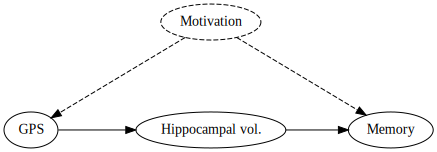

In [2]:
graph = graphviz.Digraph(engine='neato')

nodes = ['GPS', 'Hippocampal vol.', 'Memory', 'Motivation']
positions = ['0,0!', '2.5,0!', '5,0!', '2.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('Motivation', style='dashed')

graph.edge('Motivation', 'GPS', style='dashed')
graph.edge('Motivation', 'Memory', style='dashed')
graph.edge('GPS', 'Hippocampal vol.')
graph.edge('Hippocampal vol.', 'Memory')

graph

A more general version is as follows:

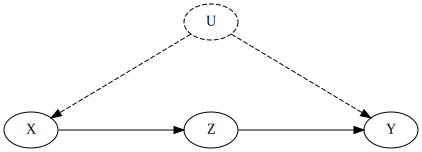

In [3]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Z', 'Y', 'U']
positions = ['0,0!', '2.5,0!', '5,0!', '2.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('U', style='dashed')

graph.edge('U', 'X', style='dashed')
graph.edge('U', 'Y', style='dashed')
graph.edge('X', 'Z')
graph.edge('Z', 'Y')

graph

Let us now build an example SCM.

In [4]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:

    def __init__(self, random_seed=42):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)

    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""

        np.random.seed(self.random_seed)

        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)

        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u

        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u

        return gps, hippocampus, memory

    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [5]:
# Instantiate the SCM
scm = GPSMemorySCM()

In [6]:
# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(600)

In [7]:
# Run an experiment
treatments = []
experiment_results = []

In [8]:
# Sample over various treatments
for treatment in np.arange(1, 21):
    gps_hours, hippocampus, memory = scm.intervene(
        treatment_value=treatment,
        sample_size=30
    )

    experiment_results.append(memory)
    treatments.append(gps_hours)

In [9]:
lr_naive = LinearRegression()
lr_naive.fit(
    X=gps_obs.reshape(-1, 1),
    y=memory_obs
)

LinearRegression()

In [10]:
treatments_unpack = np.array(treatments).flatten()
results_unpack = np.array(experiment_results).flatten()

lr_experiment = LinearRegression()
lr_experiment.fit(
    X=treatments_unpack.reshape(-1, 1),
    y=results_unpack
)

LinearRegression()

In [11]:
# Get coefficients
print(f'Naive model:\n{lr_naive.coef_[0]}\n')
print(f'Experimental model:\n{lr_experiment.coef_[0]}')

Naive model:
-0.35008979322178896

Experimental model:
-0.4199999999999999


This means the causal effect is closer to -0.42 that the naive model is unable to recover.

We can compute the valid estimate of the causal effect of X on Y in three simple steps:

1. Fit a model, $Z \sim X$
2. Fit a model, $Y \sim Z + X$
3. Multiply the coefficients from model 1 and model 2

In [12]:
# Model E(Z|X)
lr_zx = LinearRegression()
lr_zx.fit(
    X=gps_obs.reshape(-1, 1),
    y=hippocampus_obs
)

# Model E(Y|X, Z)E(X)
lr_yxz = LinearRegression()
lr_yxz.fit(
    X=np.array([gps_obs, hippocampus_obs]).T,
    y=memory_obs
)

# Compute the expected causal effect
lr_zx.coef_[0] * lr_yxz.coef_[1]

-0.3856098975970934

In [13]:
lr_zx.coef_, lr_yxz.coef_

(array([-0.60810126]), array([0.0355201, 0.6341212]))